## Dependencies

In [4]:
!pip install torch==2.1.1

^C


In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import os                       # for working with files

## Reading Data

In [7]:
import os
from PIL import Image
import numpy as np

def load_dataset(directory):
    images = []
    labels = []

    for root, dirs, files in os.walk(directory):
        for filename in files:
            if filename.endswith(('.JPG', '.jpg', '.jpeg', '.png')):  # Assuming images are in common formats
                img_path = os.path.join(root, filename)
                img = Image.open(img_path).convert('RGB')
                img = img.resize((150, 150))  # Resize the image to a consistent size
                img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
                images.append(img_array)
                
                # Extract the class label from the subdirectory name
                class_name = os.path.basename(root)
                labels.append(class_name)

    return np.array(images), np.array(labels)

# Example usage
dataset_directory = './Dataset for Crop Pest and Disease Detection/CCMT Dataset-Augmented/'
images, labels = load_dataset(dataset_directory)

# Now 'images' is a NumPy array containing your image data, and 'labels' contains corresponding labels.

KeyboardInterrupt: 

#### Read images data

In [8]:
data_dir= "./PlantVillage-Dataset/"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
diseases = os.listdir(train_dir)
diseases

FileNotFoundError: [WinError 3] The system cannot find the path specified: './PlantVillage-Dataset//train'

## Predictive Model for Crop Pest and Disease Detection    

In [10]:
print("Total disease classes are: {}".format(len(diseases)))

NameError: name 'diseases' is not defined

In [11]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1

NameError: name 'diseases' is not defined

In [12]:
# unique plants in the dataset
print(f"Unique Plants are: \n{plants}")
# number of unique plants
print("Number of plants: {}".format(len(plants)))

Unique Plants are: 
[]


In [14]:
# number of unique diseases
print("Number of diseases: {}".format(NumberOfDiseases))

Number of diseases: 0


So we have images of leaves of 14 plants and while excluding healthy leaves, we have 26 types of images that show a particular disease in a particular plant.

In [15]:
# Number of images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class 

NameError: name 'diseases' is not defined

ValueError: shape mismatch: objects cannot be broadcast to a single shape

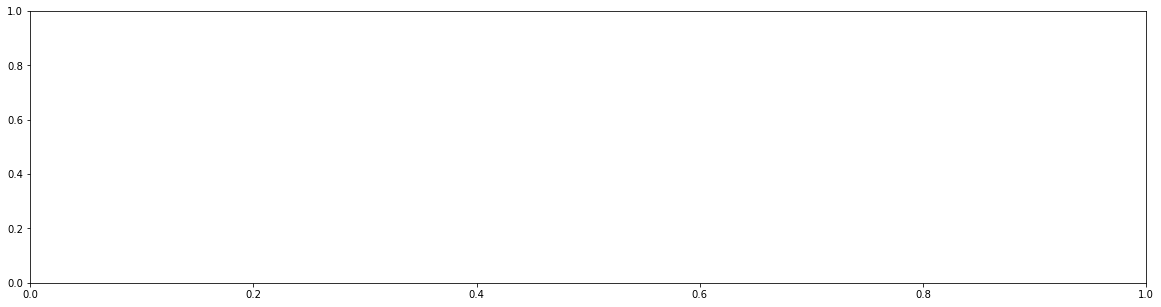

In [16]:
import matplotlib.pyplot as plt
# plotting number of images available for each disease
index = [n for n in range(38)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

We can see that the dataset is almost balanced for all classes, so we are good to go forward

#### Images available for training

In [17]:
n_train = 0
for value in nums.values():
    n_train += value
print(f"There are {n_train} images for training")

There are 0 images for training


In [ ]:

import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders 
from PIL import Image          # for checking images
# import torch.nn.functional as F # for functions for calculating loss
# import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid   
from torchvision.datasets import ImageFolder  # for working with classes and images
# datasets for validation and training
train = ImageFolder(train_dir, transform=transforms.ToTensor())
valid = ImageFolder(valid_dir, transform=transforms.ToTensor()) 

ModuleNotFoundError: No module named 'torchvision'

#### Image shape 

In [ ]:
img, label = train[0]
print(img.shape, label)
# total number of classes in train set
len(train.classes)

NameError: name 'train' is not defined

In [19]:
# for checking some images from training dataset
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))


show_image(*train[0])

NameError: name 'train' is not defined

In [ ]:
show_image(*train[70000])

NameError: name 'train' is not defined

In [ ]:
# Setting the seed value
random_seed = 7
torch.manual_seed(random_seed)

In [ ]:
# setting the batch size
batch_size = 32

In [ ]:
# DataLoaders for training and validation
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

NameError: name 'train' is not defined

- `DataLoader` is a subclass which comes from `torch.utils.data`. It helps in loading large and memory consuming datasets. It takes in `batch_size` which denotes the number of samples contained in each generated batch. 

- Setting `shuffle=True` shuffles the dataset. It is heplful so that batches between epochs do not look alike. Doing so will eventually make our model more robust.

- `num_workers`, denotes the number of processes that generate batches in parallel. If you have more cores in your CPU, you can set it to number of cores in your CPU. Since, Kaggle provides a 2 core CPU, I have set it to 2


In [ ]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

In [ ]:
# Images for first batch of training
show_batch(train_dl) 

NameError: name 'train_dl' is not defined

# Modelling

In [ ]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Checking the device we are working with

In [ ]:
device = get_default_device()
device

NameError: name 'get_default_device' is not defined

Wrap up our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available)

In [ ]:
# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

NameError: name 'DeviceDataLoader' is not defined

## Building the model architecture 

*We are going to use **ResNet**, which have been one of the major breakthrough in computer vision since they were introduced in 2015.*

#### Residual Block code implementation

In [ ]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

NameError: name 'nn' is not defined

In [ ]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))
        

NameError: name 'nn' is not defined

In [ ]:
# Architecture for training

# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


# resnet architecture 
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64 
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        
        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))
        
    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out        

NameError: name 'ImageClassificationBase' is not defined

In [ ]:
# Architecture for training

# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


# resnet architecture 
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64 
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        
        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))
        
    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out        

NameError: name 'ImageClassificationBase' is not defined

Now, we define a model object and transfer it into the device with which we are working...

In [ ]:
# defining the model and moving it to the GPU
model = to_device(ResNet9(3, len(train.classes)), device) 
model

NameError: name 'to_device' is not defined

*Getting a nicely formatted summary of our model (like in Keras). Pytorch doesn't support it natively. So, we need to install the `torchsummary` library (discussed earlier)*

In [ ]:
# getting summary of the model
INPUT_SHAPE = (3, 256, 256)
# print(summary(model.cuda(), (INPUT_SHAPE)))

# Training the model

In [ ]:
# for training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()
            
    
        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history
    

NameError: name 'torch' is not defined

Let's check our validation loss and accuracy

In [ ]:
%%time
history = [evaluate(model, valid_dl)]
history

NameError: name 'evaluate' is not defined

In [ ]:
epochs = 2
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

NameError: name 'torch' is not defined

In [ ]:
%%time
history += fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=1e-4, 
                             opt_func=opt_func)

NameError: name 'history' is not defined

#### Helper functions for plotting

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

In [ ]:
## Validation Accuracy

In [ ]:
plot_accuracies(history)

NameError: name 'history' is not defined

## Validation loss

In [ ]:
plot_losses(history)

NameError: name 'history' is not defined

## Learning Rate overtime

In [ ]:
plot_lrs(history)

NameError: name 'history' is not defined

# Testing model on test data 

**We only have 33 images in test data, so let's check the model on all images**

In [ ]:
test_dir = "../input/new-plant-diseases-dataset/test"
test = ImageFolder(test_dir, transform=transforms.ToTensor())

NameError: name 'ImageFolder' is not defined

In [ ]:
test_images = sorted(os.listdir(test_dir + '/test')) # since images in test folder are in alphabetical order
test_images

NameError: name 'os' is not defined

In [ ]:
def predict_image(img, model):
    """Converts image to array and return the predicted class
        with highest probability"""
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label

    return train.classes[preds[0].item()]

In [ ]:
# predicting first image
img, label = test[1]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_images[0], ', Predicted:', predict_image(img, model))

NameError: name 'test' is not defined

In [ ]:
# getting all predictions (actual label vs predicted)
for i, (img, label) in enumerate(test):
    print('Label:', test_images[i], ', Predicted:', predict_image(img, model))

NameError: name 'test' is not defined

**We can see that the model predicted all the test images perfectly!!!!**

# Saving the model

**There are several ways to save the model in Pytorch, following are the two most common ways**

1. **Save/Load `state_dict` (Recommended)**

When saving a model for inference, it is only necessary to save the trained model’s learned parameters. Saving the model’s `state_dict` with the `torch.save()` function will give you the most flexibility for restoring the model later, which is why it is the recommended method for saving models.

A common PyTorch convention is to save models using either a `.pt` or `.pth` file extension.

Remember that you must call `model.eval()` to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.

In [ ]:
# saving to the kaggle working directory
PATH = './plant-disease-model.pth'  
torch.save(model.state_dict(), PATH)

NameError: name 'torch' is not defined

2. **Save/Load Entire Model**

This save/load process uses the most intuitive syntax and involves the least amount of code. Saving a model in this way will save the entire module using Python’s [pickle](https://docs.python.org/3/library/pickle.html) module. The disadvantage of this approach is that the serialized data is bound to the specific classes and the exact directory structure used when the model is saved. The reason for this is because pickle does not save the model class itself. Rather, it saves a path to the file containing the class, which is used during load time. Because of this, your code can break in various ways when used in other projects or after refactors.

In [ ]:
# saving the entire model to working directory
PATH = './plant-disease-model-complete.pth'
torch.save(model, PATH)

NameError: name 'torch' is not defined

In [ ]:
print(torch.__version__)

NameError: name 'torch' is not defined

In [ ]:
print(pd.__version__)

NameError: name 'pd' is not defined

# Conclusion

ResNets perform significantly well for image classification when some of the parameters are tweaked and techniques like scheduling learning rate, gradient clipping and weight decay are applied. The model is able to predict every image in test set perfectly without any errors !!!!